In [1]:
# Transformers installation
! pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from datasets import load_dataset
from datasets import Dataset, Features, ClassLabel, Sequence, Value

def process_data(file):
      f = open(file)
      data = []
      sentences = []
      labels = []
      sentence = []
      label= []
      for line in f:
                  l=line.split('\t')
                  if len(l)==0 or l[0]=="\n" or l[0]=="  \n":
                      if len(sentence) > 0:
                          #data.append((sentence,label))
                          sentences.append(sentence)
                          labels.append(label)
                          sentence = []
                          label = []
                      continue

                  sentence.append(l[0])
                  if l[1].strip() == 'c':
                    label.append(1)
                  else:
                    label.append(0)

      if len(sentence) >0:
                  print("printing data value:", sentence, label)
                  #data.append((sentence,label))
                  sentences.append(sentence)
                  labels.append(label)
                  sentence = []
                  label = []
      
      return {'tokens': sentences, 'ner_tags': labels}


training_data_dict = process_data("train.tsv")
testing_data_dict = process_data("dev.tsv")
testing_data_dict_1 = process_data("test.tsv")
features = Features({'tokens': Sequence(feature=Value(dtype='string', id=None)), 'ner_tags': Sequence(feature=ClassLabel(names=['i', 'c'], id=None), length=-1, id=None)})

my_dataset = Dataset.from_dict({
    'tokens': training_data_dict['tokens'],
    'ner_tags': training_data_dict['ner_tags']
}, features=features)

test_dataset = Dataset.from_dict({
    'tokens': testing_data_dict['tokens'],
    'ner_tags': testing_data_dict['ner_tags']
}, features=features)

test_dataset_1 = Dataset.from_dict({
    'tokens': testing_data_dict_1['tokens'],
    'ner_tags': testing_data_dict_1['ner_tags']
}, features=features)

print("first training example:", my_dataset["tokens"][0])

first training example: ['Dear', 'Sir', 'or', 'Madam', ',']


In [4]:
label_list = my_dataset.features[f"ner_tags"].feature.names
label_list

['i', 'c']

## Preprocess

In [5]:
from transformers import GPT2Tokenizer
from transformers import GPT2Config, GPT2Model
from transformers import AutoTokenizer, OpenAIGPTModel
# Initializing a GPT2 configuration
configuration = GPT2Config()

# Initializing a model (with random weights) from the configuration
model = GPT2Model(configuration)

# Accessing the model configuration
configuration = model.config
tokenizer = AutoTokenizer.from_pretrained("brad1141/gpt2-finetuned-comp2", add_prefix_space=True)
tokenizer.pad_token = tokenizer.eos_token

In [6]:
example = my_dataset["tokens"][0]
print("example:", example)
tokenized_input = tokenizer(example,is_split_into_words=True)
print(len(tokenized_input["input_ids"]))
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

example: ['Dear', 'Sir', 'or', 'Madam', ',']
6


['ĠDear', 'ĠSir', 'Ġor', 'ĠMad', 'am', 'Ġ,']

In [7]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        # print("sentence:", tokenized_inputs["input_ids"])
        # print(word_ids)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
tokenized_train_data = my_dataset.map(tokenize_and_align_labels, batched=True)

tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data_1 = test_dataset_1.map(tokenize_and_align_labels, batched=True)
print(tokenized_test_data_1['labels'][0])

Map:   0%|          | 0/28731 [00:00<?, ? examples/s]

Map:   0%|          | 0/2222 [00:00<?, ? examples/s]

Map:   0%|          | 0/2720 [00:00<?, ? examples/s]

[1, 1, 1]


In [9]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
print(tokenizer)

GPT2TokenizerFast(name_or_path='brad1141/gpt2-finetuned-comp2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)


## Train

Before you start training your model, create a map of the expected ids to their labels with `id2label` and `label2id`:

In [10]:
id2label = {
    0: "i",
    1: "c"
}
label2id = {
    "i": 0,
    "c": 1
}

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load DistilBERT with [AutoModelForTokenClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForTokenClassification) along with the number of expected labels, and the label mappings:

In [11]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import GPT2ForTokenClassification, GPTBigCodeModel, GPTNeoForCausalLM, OpenAIGPTModel
model = GPT2ForTokenClassification.from_pretrained("brad1141/gpt2-finetuned-comp2", num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at brad1141/gpt2-finetuned-comp2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
!pip install --upgrade accelerate
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
training_args = TrainingArguments(
    output_dir="gpt2-token-class",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=None,
)

trainer.train()

Cloning https://huggingface.co/Varunreddy/gpt2-token-class into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.317700,0.318196
2,0.294700,0.312160
3,0.280800,0.308712
4,0.265700,0.312384
5,0.253700,0.313406
6,0.244600,0.314299
7,0.238700,0.318178


TrainOutput(global_step=12572, training_loss=0.27406492970606494, metrics={'train_runtime': 2502.0253, 'train_samples_per_second': 80.382, 'train_steps_per_second': 5.025, 'total_flos': 4222091685041508.0, 'train_loss': 0.27406492970606494, 'epoch': 7.0})

In [19]:
loss_history = trainer.state.log_history

In [20]:

train_loss_values = []
train_loss_epochs = []
eval_loss_values = []
eval_loss_epochs = []

for log in loss_history:
  if "loss" in log:
    train_loss_values.append(log["loss"])
    train_loss_epochs.append(log["epoch"])
  if "train_loss" in log:
    train_loss_values.append(log["train_loss"])
    train_loss_epochs.append(log["epoch"])
  if "eval_loss" in log:
    eval_loss_values.append(log["eval_loss"])
    eval_loss_epochs.append(log["epoch"])

train_loss_values

[0.3662,
 0.3288,
 0.3177,
 0.3132,
 0.3002,
 0.297,
 0.2947,
 0.2818,
 0.2817,
 0.2808,
 0.2752,
 0.2684,
 0.2666,
 0.2657,
 0.2593,
 0.2536,
 0.2537,
 0.2549,
 0.2472,
 0.245,
 0.2446,
 0.2418,
 0.2366,
 0.2449,
 0.2387,
 0.27406492970606494]

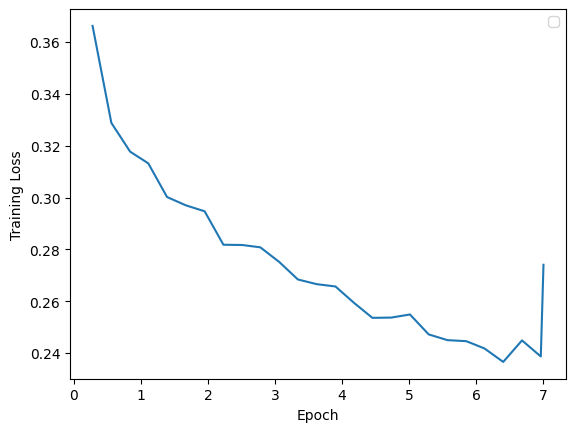

In [21]:
# Plotting Training Loss Curve

import matplotlib.pyplot as plt
plt.plot(train_loss_epochs, train_loss_values)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

[0.31819576025009155, 0.31215983629226685, 0.3087124824523926, 0.3123838007450104, 0.31340640783309937, 0.3142992854118347, 0.3181777596473694]


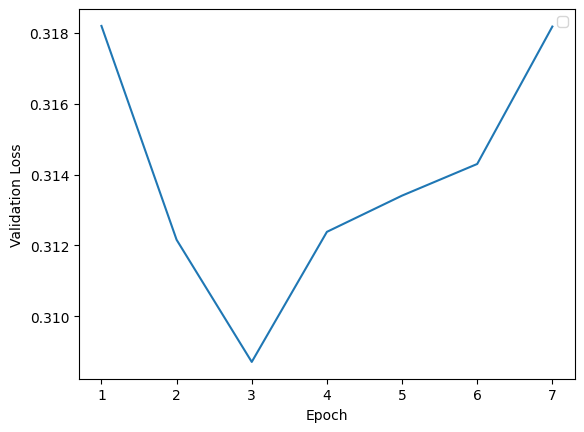

In [22]:
# Plotting Validation Loss Curve

import matplotlib.pyplot as plt
print(eval_loss_values)
plt.plot(eval_loss_epochs, eval_loss_values)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [23]:
trainer.push_to_hub()
# trainer.save_model("/")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/May17_17-01-01_1f7324fa30e5/events.out.tfevents.1684342873.1f7324fa30e5.2674.0:   0%|        …

To https://huggingface.co/Varunreddy/gpt2-token-class
   48474ef..3e13fff  main -> main

   48474ef..3e13fff  main -> main

To https://huggingface.co/Varunreddy/gpt2-token-class
   3e13fff..37c36b4  main -> main

   3e13fff..37c36b4  main -> main



'https://huggingface.co/Varunreddy/gpt2-token-class/commit/3e13fff77039b535307b7d37c2e7d3d6ad039fb9'

In [24]:
text = "I saws an eye."

In [26]:
from transformers import pipeline

classifier = pipeline("ner", model="Varunreddy/gpt2-token-class")
classifier(text)

[{'entity': 'c',
  'score': 0.9881386,
  'index': 0,
  'word': 'ĠI',
  'start': 0,
  'end': 1},
 {'entity': 'c',
  'score': 0.96566087,
  'index': 1,
  'word': 'Ġsaw',
  'start': 1,
  'end': 5},
 {'entity': 'c',
  'score': 0.6244459,
  'index': 2,
  'word': 's',
  'start': 5,
  'end': 6},
 {'entity': 'c',
  'score': 0.8087578,
  'index': 3,
  'word': 'Ġan',
  'start': 6,
  'end': 9},
 {'entity': 'c',
  'score': 0.8954454,
  'index': 4,
  'word': 'Ġeye',
  'start': 9,
  'end': 13},
 {'entity': 'c',
  'score': 0.9876324,
  'index': 5,
  'word': '.',
  'start': 13,
  'end': 14}]

In [27]:
from transformers import AutoTokenizer



# # text = ['i', 'saws', 'an', 'eye']
# tokenizer = AutoTokenizer.from_pretrained("vp224/gpt2-token-class")
# inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, is_split_into_words=True)
# print(tokenized_test_data_1['tokens'][2])
# print(len(tokenized_test_data_1['tokens'][2]))
# print((inputs))

In [29]:
import torch
from torch import cuda
from transformers import AutoModelForTokenClassification
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)
model = AutoModelForTokenClassification.from_pretrained("Varunreddy/gpt2-token-class")
eval_preds, eval_labels = [], []
with torch.no_grad():
  print(len(testing_data_dict_1['tokens']))
  for idx in range(len(testing_data_dict_1['tokens'])):
    ids = torch.Tensor(tokenized_test_data_1['input_ids'][idx]).to(dtype = torch.long)
    mask = torch.Tensor(tokenized_test_data_1['attention_mask'][idx]).to(dtype = torch.long)
    targets = torch.Tensor(tokenized_test_data_1['labels'][idx]).to(dtype = torch.long)
    



    logits = model(input_ids=ids, attention_mask=mask).logits
    # loss = model(input_ids=ids, attention_mask=mask, labels=targets)
    predictions = torch.argmax(logits, dim=1)
    predictions = predictions.tolist()
    # print(predictions)
    eval_labels.extend(targets.tolist())
    eval_preds.extend(predictions)

    if len(targets.tolist()) != len(predictions):
      print("No match")
    # print(loss)
    # logits = model(**inputs).logits
  print(eval_labels)
  print(eval_preds)

cuda
2720
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -100, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, -100, 1, 0, 1, 1, -100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, -100, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,

Pass your inputs to the model and return the `logits`:

In [30]:
new_labels = []
new_predictions = []
for i in range(len(eval_labels)):
    if(eval_labels[i]!=-100):
      new_labels.append(eval_labels[i])
      new_predictions.append(eval_preds[i])

print(len(new_labels))
print(len(new_predictions))


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

results = accuracy_score(new_labels, new_predictions)
print("accuracy: ", results)
print("precision: ",precision_score(new_labels, new_predictions,average='macro'))
print("recall: ",recall_score(new_labels, new_predictions,average='macro'))
print( "F-0.5 score:", fbeta_score(new_labels, new_predictions,average='macro', beta=0.5))

41477
41477
accuracy:  0.8750632880873738
precision:  0.8239172966579851
recall:  0.6209485854628254
F-0.5 score: 0.7240256910546943
